# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [1]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.describe()

,titulo,texto,link,resumo,categoria,data_hora
count,3877,3877,3877,3877,3877,3877
unique,3877,3705,3619,3574,11,3522
top,"Veja a trajetória de Fernando Diniz, em busca ...",,https://www.cnnbrasil.com.br/economia/mercado-...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-08 12:14:27
freq,1,40,7,9,960,7


In [5]:
df = df.dropna(subset=['texto'])

# Remover linhas com listas vazias
df= df[df['texto'].apply(lambda x: len(x) > 0)]

In [6]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [7]:
df['categoria'].value_counts()

esportes           920
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

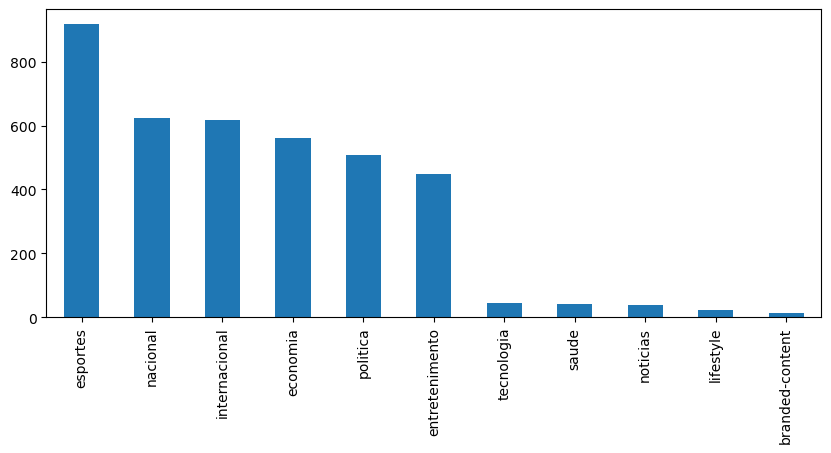

In [8]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [9]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [10]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [11]:
df['categoria'].value_counts()

esportes          920
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

In [12]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [13]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

In [14]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Felipe Melo detona fala de Mbappé sobre a Amér...,Recentemente campeão da Copa Libertadores pelo...,https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor criticou a postura do astro francês p...,esportes,2023-11-09 19:07:34
1,Campeonato Alemão terá mulher como auxiliar té...,O Union Berlin demitiu Urs Fischer nesta quint...,https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45
2,Grêmio: Suárez indo para Inter Miami? Veja o q...,"Se por um lado a torcida do Grêmio curte, e ta...",https://www.cnnbrasil.com.br/esportes/gremio-s...,Centroavante deixará o Tricolor em dezembro de...,esportes,2023-11-21 20:18:58
3,Flamengo x Atlético-MG: Tite e Felipão se abra...,A rusga do passado entre Tite e Luiz Felipe Sc...,https://www.cnnbrasil.com.br/esportes/flamengo...,Os treinadores não se enfrentavam desde 2012 e...,esportes,2023-11-29 23:27:58
4,Brasil x Argentina: veja prováveis escalações ...,Brasil e Argentina se enfrentam nesta terça-fe...,https://www.cnnbrasil.com.br/esportes/brasil-x...,Confronto pela sexta rodada será nesta terça-f...,esportes,2023-11-20 21:01:58


In [15]:
df_balanceado2 = df_balanceado.copy()
df_balanceado3 = df_balanceado.copy()

In [16]:
df_balanceado2.head()

,titulo,texto,link,resumo,categoria,data_hora
0,Felipe Melo detona fala de Mbappé sobre a Amér...,Recentemente campeão da Copa Libertadores pelo...,https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor criticou a postura do astro francês p...,esportes,2023-11-09 19:07:34
1,Campeonato Alemão terá mulher como auxiliar té...,O Union Berlin demitiu Urs Fischer nesta quint...,https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45
2,Grêmio: Suárez indo para Inter Miami? Veja o q...,"Se por um lado a torcida do Grêmio curte, e ta...",https://www.cnnbrasil.com.br/esportes/gremio-s...,Centroavante deixará o Tricolor em dezembro de...,esportes,2023-11-21 20:18:58
3,Flamengo x Atlético-MG: Tite e Felipão se abra...,A rusga do passado entre Tite e Luiz Felipe Sc...,https://www.cnnbrasil.com.br/esportes/flamengo...,Os treinadores não se enfrentavam desde 2012 e...,esportes,2023-11-29 23:27:58
4,Brasil x Argentina: veja prováveis escalações ...,Brasil e Argentina se enfrentam nesta terça-fe...,https://www.cnnbrasil.com.br/esportes/brasil-x...,Confronto pela sexta rodada será nesta terça-f...,esportes,2023-11-20 21:01:58


In [17]:
df_balanceado3.head()

,titulo,texto,link,resumo,categoria,data_hora
0,Felipe Melo detona fala de Mbappé sobre a Amér...,Recentemente campeão da Copa Libertadores pelo...,https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor criticou a postura do astro francês p...,esportes,2023-11-09 19:07:34
1,Campeonato Alemão terá mulher como auxiliar té...,O Union Berlin demitiu Urs Fischer nesta quint...,https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45
2,Grêmio: Suárez indo para Inter Miami? Veja o q...,"Se por um lado a torcida do Grêmio curte, e ta...",https://www.cnnbrasil.com.br/esportes/gremio-s...,Centroavante deixará o Tricolor em dezembro de...,esportes,2023-11-21 20:18:58
3,Flamengo x Atlético-MG: Tite e Felipão se abra...,A rusga do passado entre Tite e Luiz Felipe Sc...,https://www.cnnbrasil.com.br/esportes/flamengo...,Os treinadores não se enfrentavam desde 2012 e...,esportes,2023-11-29 23:27:58
4,Brasil x Argentina: veja prováveis escalações ...,Brasil e Argentina se enfrentam nesta terça-fe...,https://www.cnnbrasil.com.br/esportes/brasil-x...,Confronto pela sexta rodada será nesta terça-f...,esportes,2023-11-20 21:01:58


In [18]:
# pega coluna
text = df_balanceado['texto'] # para NLTK
text2 = df_balanceado2['texto'] # para spaCy
text3 = df_balanceado3['texto'] # para Gensim
len(text)

2700

In [19]:
text[0]

'Recentemente campeão da Copa Libertadores pelo Fluminense, Felipe Melo fez fortes críticas ao astro Mbappé, do PSG e da Seleção Francesa. O personagem da conquista inédita do Tricolor criticou as falas do atacante francês a respeito da qualidade do futebol sul-americano. Mbappé é um tolo. Marcou três gols na final, ok, mas a Argentina sagrou-se campeã e Messi foi o melhor do mundo. Ele ainda tem muito que aprender, não pode falar do futebol sul-americano  O brasileiro ainda exaltou a qualidade de Mbappé, mas reiterou que o jovem precisa tomar mais cuidado ao falar sobre a situação do futebol longe do cenário europeu. “Para mim ele é um grande jogador, que vai ganhar 3 ou 4 Bolas de Ouro, mas tem que ficar de boca fechada. Eles vêm da Europa em busca de jogadores aqui (América do Sul), não na França. Felizmente não tive a oportunidade de jogar contra ele (Mbappé), felizmente não sei se é por mim ou por ele”, finalizou.  Leia Mais  Antes da Copa do Mundo de 2022, Mbappé concedeu entrevi

In [20]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

### NLTK

In [21]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [22]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [23]:
print(token_text[0])

['recentemente', 'campeão', 'da', 'copa', 'libertadores', 'pelo', 'fluminense', ',', 'felipe', 'melo', 'fez', 'fortes', 'críticas', 'ao', 'astro', 'mbappé', ',', 'do', 'psg', 'e', 'da', 'seleção', 'francesa', '.', 'o', 'personagem', 'da', 'conquista', 'inédita', 'do', 'tricolor', 'criticou', 'as', 'falas', 'do', 'atacante', 'francês', 'a', 'respeito', 'da', 'qualidade', 'do', 'futebol', 'sul-americano', '.', 'mbappé', 'é', 'um', 'tolo', '.', 'marcou', 'três', 'gols', 'na', 'final', ',', 'ok', ',', 'mas', 'a', 'argentina', 'sagrou-se', 'campeã', 'e', 'messi', 'foi', 'o', 'melhor', 'do', 'mundo', '.', 'ele', 'ainda', 'tem', 'muito', 'que', 'aprender', ',', 'não', 'pode', 'falar', 'do', 'futebol', 'sul-americano', 'o', 'brasileiro', 'ainda', 'exaltou', 'a', 'qualidade', 'de', 'mbappé', ',', 'mas', 'reiterou', 'que', 'o', 'jovem', 'precisa', 'tomar', 'mais', 'cuidado', 'ao', 'falar', 'sobre', 'a', 'situação', 'do', 'futebol', 'longe', 'do', 'cenário', 'europeu', '.', '“', 'para', 'mim', 'e

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [26]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [27]:
print(token_text[0])

['recentemente', 'campeão', 'copa', 'libertadores', 'fluminense', ',', 'felipe', 'melo', 'fez', 'fortes', 'críticas', 'astro', 'mbappé', ',', 'psg', 'seleção', 'francesa', '.', 'personagem', 'conquista', 'inédita', 'tricolor', 'criticou', 'falas', 'atacante', 'francês', 'respeito', 'qualidade', 'futebol', 'sul-americano', '.', 'mbappé', 'tolo', '.', 'marcou', 'três', 'gols', 'final', ',', 'ok', ',', 'argentina', 'sagrou-se', 'campeã', 'messi', 'melhor', 'mundo', '.', 'ainda', 'aprender', ',', 'pode', 'falar', 'futebol', 'sul-americano', 'brasileiro', 'ainda', 'exaltou', 'qualidade', 'mbappé', ',', 'reiterou', 'jovem', 'precisa', 'tomar', 'cuidado', 'falar', 'sobre', 'situação', 'futebol', 'longe', 'cenário', 'europeu', '.', '“', 'mim', 'grande', 'jogador', ',', 'vai', 'ganhar', '3', '4', 'bolas', 'ouro', ',', 'ficar', 'boca', 'fechada', '.', 'vêm', 'europa', 'busca', 'jogadores', 'aqui', '(', 'américa', 'sul', ')', ',', 'frança', '.', 'felizmente', 'oportunidade', 'jogar', 'contra', '(

In [28]:
for i in range(len(token_text)):
    token_text[i] = ' '.join(token_text[i])
print(token_text[0])

recentemente campeão copa libertadores fluminense , felipe melo fez fortes críticas astro mbappé , psg seleção francesa . personagem conquista inédita tricolor criticou falas atacante francês respeito qualidade futebol sul-americano . mbappé tolo . marcou três gols final , ok , argentina sagrou-se campeã messi melhor mundo . ainda aprender , pode falar futebol sul-americano brasileiro ainda exaltou qualidade mbappé , reiterou jovem precisa tomar cuidado falar sobre situação futebol longe cenário europeu . “ mim grande jogador , vai ganhar 3 4 bolas ouro , ficar boca fechada . vêm europa busca jogadores aqui ( américa sul ) , frança . felizmente oportunidade jogar contra ( mbappé ) , felizmente sei mim ” , finalizou . leia antes copa mundo 2022 , mbappé concedeu entrevista tnt sports afirmou futebol sul-americano “ tão avançado ” quanto futebol europeu . declaração rendeu desconforto atletas latinos atuam velho continente . “ penso brasil [ favorito ] , brasil boa equipe . existem vária

In [29]:
from unidecode import unidecode

for i in range(len(token_text)):
    token_text[i] = unidecode(token_text[i])

In [30]:
for i in range(len(token_text)):
    token_text[i] = re.sub(r'[^a-zA-Z\s]', "" ,token_text[i])

In [31]:
t_text = []

for j in token_text:
    t_text.append(nltk.word_tokenize(j))
    
token_text = t_text

In [32]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Felipe Melo detona fala de Mbappé sobre a Amér...,"[recentemente, campeao, copa, libertadores, fl...",https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor criticou a postura do astro francês p...,esportes,2023-11-09 19:07:34
1,Campeonato Alemão terá mulher como auxiliar té...,"[union, berlin, demitiu, urs, fischer, nesta, ...",https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45


### spaCy

In [33]:
for i in range(len(text2)):
    text2[i] = text2[i].lower()

In [34]:
nlp = spacy.load('pt_core_news_sm')

doc = []

for j in text2:
    temp = nlp(j)
    doc.append(temp)
print(doc[0])

recentemente campeão da copa libertadores pelo fluminense, felipe melo fez fortes críticas ao astro mbappé, do psg e da seleção francesa. o personagem da conquista inédita do tricolor criticou as falas do atacante francês a respeito da qualidade do futebol sul-americano. mbappé é um tolo. marcou três gols na final, ok, mas a argentina sagrou-se campeã e messi foi o melhor do mundo. ele ainda tem muito que aprender, não pode falar do futebol sul-americano  o brasileiro ainda exaltou a qualidade de mbappé, mas reiterou que o jovem precisa tomar mais cuidado ao falar sobre a situação do futebol longe do cenário europeu. “para mim ele é um grande jogador, que vai ganhar 3 ou 4 bolas de ouro, mas tem que ficar de boca fechada. eles vêm da europa em busca de jogadores aqui (américa do sul), não na frança. felizmente não tive a oportunidade de jogar contra ele (mbappé), felizmente não sei se é por mim ou por ele”, finalizou.  leia mais  antes da copa do mundo de 2022, mbappé concedeu entrevis

In [35]:
token_text2 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(text2)):
    temp = [token.text for token in doc[i] if not token.is_space]
    token_text2.append(temp)

print(token_text2[0])

['recentemente', 'campeão', 'da', 'copa', 'libertadores', 'pelo', 'fluminense', ',', 'felipe', 'melo', 'fez', 'fortes', 'críticas', 'ao', 'astro', 'mbappé', ',', 'do', 'psg', 'e', 'da', 'seleção', 'francesa', '.', 'o', 'personagem', 'da', 'conquista', 'inédita', 'do', 'tricolor', 'criticou', 'as', 'falas', 'do', 'atacante', 'francês', 'a', 'respeito', 'da', 'qualidade', 'do', 'futebol', 'sul-americano', '.', 'mbappé', 'é', 'um', 'tolo', '.', 'marcou', 'três', 'gols', 'na', 'final', ',', 'ok', ',', 'mas', 'a', 'argentina', 'sagrou-se', 'campeã', 'e', 'messi', 'foi', 'o', 'melhor', 'do', 'mundo', '.', 'ele', 'ainda', 'tem', 'muito', 'que', 'aprender', ',', 'não', 'pode', 'falar', 'do', 'futebol', 'sul-americano', 'o', 'brasileiro', 'ainda', 'exaltou', 'a', 'qualidade', 'de', 'mbappé', ',', 'mas', 'reiterou', 'que', 'o', 'jovem', 'precisa', 'tomar', 'mais', 'cuidado', 'ao', 'falar', 'sobre', 'a', 'situação', 'do', 'futebol', 'longe', 'do', 'cenário', 'europeu', '.', '“', 'para', 'mim', 'e

In [36]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop = STOP_WORDS
#print(stop)

In [37]:
token2 = []
for i in token_text2:
    temp = []
    for token in i:
        if token not in stop:
            temp.append(token)
    token2.append(temp)
print(token2[0])

['recentemente', 'campeão', 'copa', 'libertadores', 'fluminense', ',', 'felipe', 'melo', 'fortes', 'críticas', 'astro', 'mbappé', ',', 'psg', 'seleção', 'francesa', '.', 'personagem', 'conquista', 'inédita', 'tricolor', 'criticou', 'falas', 'atacante', 'francês', 'respeito', 'qualidade', 'futebol', 'sul-americano', '.', 'mbappé', 'tolo', '.', 'marcou', 'gols', ',', 'ok', ',', 'argentina', 'sagrou-se', 'campeã', 'messi', 'melhor', 'mundo', '.', 'aprender', ',', 'falar', 'futebol', 'sul-americano', 'brasileiro', 'exaltou', 'qualidade', 'mbappé', ',', 'reiterou', 'jovem', 'precisa', 'tomar', 'cuidado', 'falar', 'situação', 'futebol', 'cenário', 'europeu', '.', '“', 'mim', 'jogador', ',', 'ganhar', '3', '4', 'bolas', 'ouro', ',', 'ficar', 'boca', 'fechada', '.', 'europa', 'busca', 'jogadores', '(', 'américa', 'sul', ')', ',', 'frança', '.', 'felizmente', 'oportunidade', 'jogar', '(', 'mbappé', ')', ',', 'felizmente', 'mim', '”', ',', 'finalizou', '.', 'leia', 'copa', 'mundo', '2022', ',', 

In [38]:
token22 = []
for i in token2:
    token22.append(' '.join(i))
token22[0]

'recentemente campeão copa libertadores fluminense , felipe melo fortes críticas astro mbappé , psg seleção francesa . personagem conquista inédita tricolor criticou falas atacante francês respeito qualidade futebol sul-americano . mbappé tolo . marcou gols , ok , argentina sagrou-se campeã messi melhor mundo . aprender , falar futebol sul-americano brasileiro exaltou qualidade mbappé , reiterou jovem precisa tomar cuidado falar situação futebol cenário europeu . “ mim jogador , ganhar 3 4 bolas ouro , ficar boca fechada . europa busca jogadores ( américa sul ) , frança . felizmente oportunidade jogar ( mbappé ) , felizmente mim ” , finalizou . leia copa mundo 2022 , mbappé concedeu entrevista tnt sports afirmou futebol sul-americano “ avançado ” futebol europeu . declaração rendeu desconforto atletas latinos atuam velho continente . “ penso brasil [ favorito ] , brasil equipe . existem várias equipes europeias , vantagem jogamos partidas alto . nations [ league ] , . gente chega copa 

In [39]:
from unidecode import unidecode

for i in range(len(token22)):
    token22[i] = unidecode(token22[i])

In [40]:
for i in range(len(token22)):
   token22[i] = re.sub(r'[^a-zA-Z\s]', "" ,token22[i])

In [41]:
nlp = spacy.load('pt_core_news_sm')

doct = []

for j in token22:
    temp = nlp(j)
    doct.append(temp)
    
token_text22 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(token22)):
    temp = [token.text for token in doct[i] if not token.is_space]
    token_text22.append(temp)

print(token_text22[0])

['recentemente', 'campeao', 'copa', 'libertadores', 'fluminense', 'felipe', 'melo', 'fortes', 'criticas', 'astro', 'mbappe', 'psg', 'selecao', 'francesa', 'personagem', 'conquista', 'inedita', 'tricolor', 'criticou', 'falas', 'atacante', 'frances', 'respeito', 'qualidade', 'futebol', 'sulamericano', 'mbappe', 'tolo', 'marcou', 'gols', 'ok', 'argentina', 'sagrouse', 'campea', 'messi', 'melhor', 'mundo', 'aprender', 'falar', 'futebol', 'sulamericano', 'brasileiro', 'exaltou', 'qualidade', 'mbappe', 'reiterou', 'jovem', 'precisa', 'tomar', 'cuidado', 'falar', 'situacao', 'futebol', 'cenario', 'europeu', 'mim', 'jogador', 'ganhar', 'bolas', 'ouro', 'ficar', 'boca', 'fechada', 'europa', 'busca', 'jogadores', 'america', 'sul', 'franca', 'felizmente', 'oportunidade', 'jogar', 'mbappe', 'felizmente', 'mim', 'finalizou', 'leia', 'copa', 'mundo', 'mbappe', 'concedeu', 'entrevista', 'tnt', 'sports', 'afirmou', 'futebol', 'sulamericano', 'avancado', 'futebol', 'europeu', 'declaracao', 'rendeu', 'd

In [42]:
token2 = token_text22

In [43]:
df_balanceado2['texto'] = token2
df_balanceado2.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Felipe Melo detona fala de Mbappé sobre a Amér...,"[recentemente, campeao, copa, libertadores, fl...",https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor criticou a postura do astro francês p...,esportes,2023-11-09 19:07:34
1,Campeonato Alemão terá mulher como auxiliar té...,"[union, berlin, demitiu, urs, fischer, quintaf...",https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45


### Gensim

In [44]:
from gensim.utils import simple_preprocess
from gensim.utils import tokenize

In [45]:
for i in range(len(text3)):
   text3[i] = re.sub(r'[^a-zA-Z\s]', "" ,text3[i])

In [46]:
for i in range(len(text3)):
    text3[i] = simple_preprocess(text3[i], deacc=False, min_len=3)

In [47]:
stopwords = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

#print(stopwords)

In [48]:
token3 = []
for i in text3:
    temp = []
    for token in i:
        if token not in stopwords:
            temp.append(token)
    token3.append(temp)
print(token3[0])

['recentemente', 'campeo', 'copa', 'libertadores', 'fluminense', 'felipe', 'melo', 'fortes', 'crticas', 'astro', 'mbapp', 'psg', 'seleo', 'francesa', 'personagem', 'conquista', 'indita', 'tricolor', 'criticou', 'falas', 'atacante', 'francs', 'respeito', 'qualidade', 'futebol', 'sulamericano', 'mbapp', 'tolo', 'marcou', 'trs', 'gols', 'argentina', 'sagrouse', 'campe', 'messi', 'melhor', 'mundo', 'aprender', 'falar', 'futebol', 'sulamericano', 'brasileiro', 'exaltou', 'qualidade', 'mbapp', 'reiterou', 'jovem', 'precisa', 'tomar', 'cuidado', 'falar', 'situao', 'futebol', 'cenrio', 'europeu', 'mim', 'jogador', 'ganhar', 'bolas', 'ouro', 'ficar', 'boca', 'fechada', 'europa', 'busca', 'jogadores', 'amrica', 'sul', 'frana', 'felizmente', 'oportunidade', 'jogar', 'mbapp', 'felizmente', 'mim', 'finalizou', 'leia', 'copa', 'mundo', 'mbapp', 'concedeu', 'entrevista', 'tnt', 'sports', 'afirmou', 'futebol', 'sulamericano', 'est', 'avanado', 'futebol', 'europeu', 'declarao', 'rendeu', 'desconforto',

In [49]:
df_balanceado3['texto'] = token3
df_balanceado3.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Felipe Melo detona fala de Mbappé sobre a Amér...,"[recentemente, campeo, copa, libertadores, flu...",https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor criticou a postura do astro francês p...,esportes,2023-11-09 19:07:34
1,Campeonato Alemão terá mulher como auxiliar té...,"[union, berlin, demitiu, urs, fischer, quintaf...",https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45


## Análises

### NLTK

In [50]:
# Contagem de frequência de palavras usando NLTK 

#from collections import Counter
#frequencia_palavras = Counter(token_text[0]) 
#print(frequencia_palavras.most_common(10))

from nltk.probability import FreqDist

freq_dist = FreqDist(token_text[0])
# Exibição da frequência de cada palavra
#for token, freq in freq_dist.items():
#    print(token, freq)

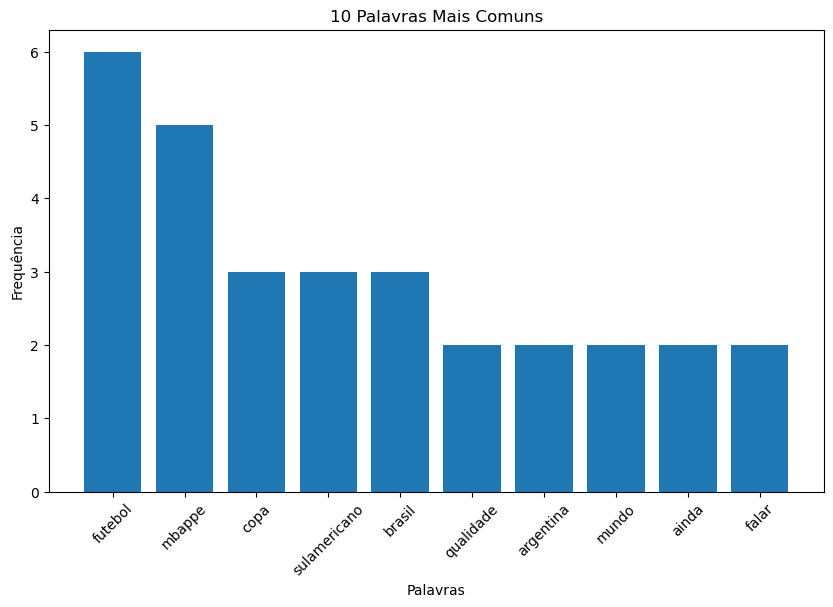

In [51]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = freq_dist.most_common(10)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

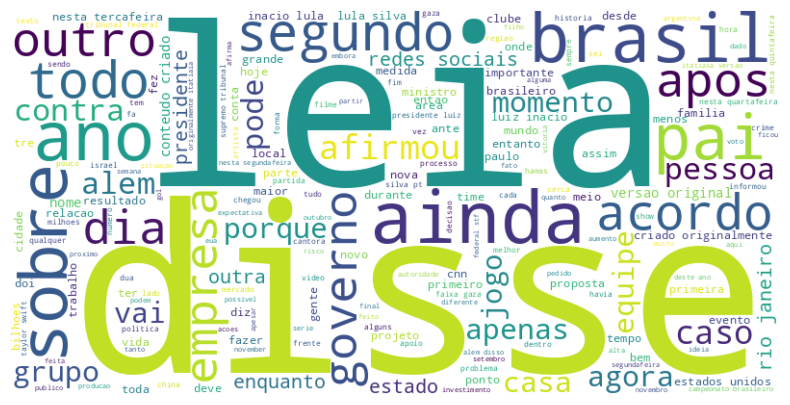

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token_text])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### spaCy

In [53]:
from spacy.attrs import ORTH # Contagem de frequência de palavras usando Spacy

doc_sp = nlp(" ".join(token2[0]))

count_dict = doc_sp.count_by(ORTH)

In [54]:
sorted_counts = sorted(count_dict.items(), key=lambda item: item[1], reverse=True)

# 10 mais frequentes
top_10_frequent_words = sorted_counts[:10]

# Print
for word, count in top_10_frequent_words:
    print(nlp.vocab.strings[word], count)

futebol 6
mbappe 5
copa 3
sulamericano 3
brasil 3
qualidade 2
argentina 2
mundo 2
falar 2
europeu 2


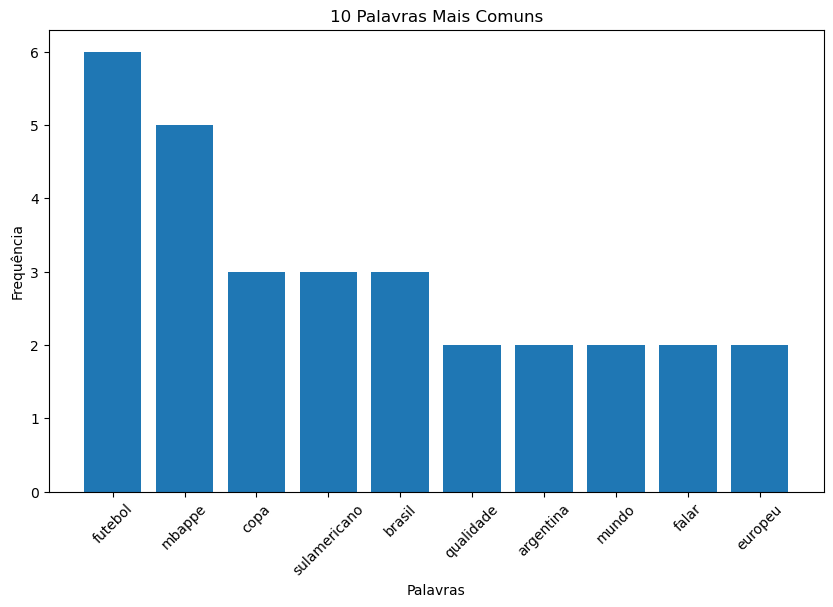

In [55]:
palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in top_10_frequent_words:
    palavras.append(nlp.vocab.strings[word])
    contagens.append(count)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

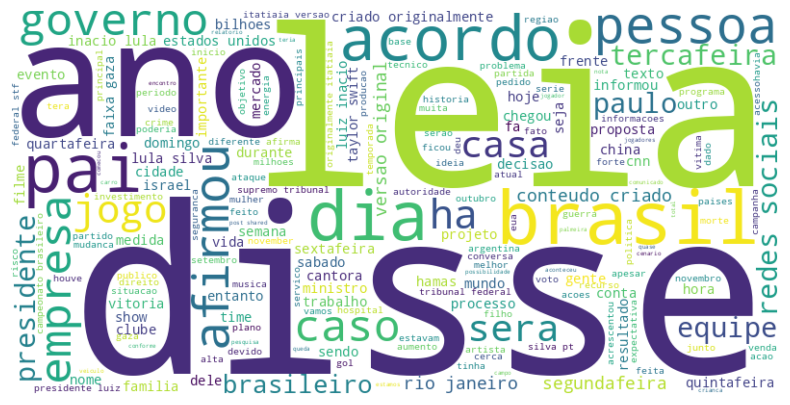

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token2])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Gensim

In [57]:
from gensim import corpora

dictionary = corpora.Dictionary(token3) 
corpus = [dictionary.doc2bow(text) for text in token3]
print(corpus[1])

[(31, 1), (34, 1), (36, 1), (53, 1), (68, 1), (74, 1), (103, 1), (108, 1), (109, 1), (110, 1), (111, 5), (112, 1), (113, 1), (114, 2), (115, 2), (116, 1), (117, 1), (118, 1), (119, 2), (120, 1), (121, 1), (122, 1), (123, 1), (124, 3), (125, 3), (126, 2), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 2), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 1), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 3), (156, 1), (157, 1), (158, 1), (159, 3), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 4), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 3), (173, 2), (174, 1), (175, 1), (176, 1), (177, 2), (178, 1), (179, 1), (180, 1), (181, 1), (182, 1), (183, 1), (184, 1), (185, 1), (186, 1), (187, 1), (188, 1), (189, 1), (190, 1), (191, 1), (192, 1), (193, 1), (194, 1), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1), (200, 1), (201,

In [58]:
mapping = {v: k for k, v in dictionary.token2id.items()}
ttt = [[(mapping[i[0]], i[1]) for i in item] for item in corpus]
print(ttt[0])

[('afirmou', 1), ('alto', 1), ('amrica', 2), ('aprender', 1), ('argentina', 2), ('aspecto', 1), ('astro', 1), ('atacante', 1), ('atletas', 1), ('atuam', 1), ('avanado', 2), ('boca', 1), ('bolas', 1), ('brasil', 3), ('brasileiro', 1), ('busca', 1), ('campe', 1), ('campeo', 1), ('cenrio', 1), ('chega', 1), ('concedeu', 1), ('conquista', 1), ('continente', 1), ('copa', 3), ('copas', 1), ('criticou', 1), ('crticas', 1), ('cuidado', 1), ('declarao', 1), ('desconforto', 1), ('entrevista', 1), ('equipe', 1), ('equipes', 1), ('est', 1), ('europa', 2), ('europeias', 1), ('europeu', 2), ('europeus', 1), ('exaltou', 1), ('existem', 1), ('falar', 2), ('falas', 1), ('favorito', 1), ('fechada', 1), ('felipe', 1), ('felizmente', 2), ('ficar', 1), ('finalizou', 1), ('fluminense', 1), ('fortes', 1), ('frana', 1), ('francesa', 1), ('francs', 1), ('futebol', 6), ('ganham', 1), ('ganhar', 1), ('gente', 1), ('gols', 1), ('indita', 1), ('jogador', 2), ('jogadores', 1), ('jogamos', 1), ('jogar', 1), ('jovem'

In [59]:
sorted_ttt = sorted(ttt[0], key=lambda x: x[1], reverse=True)

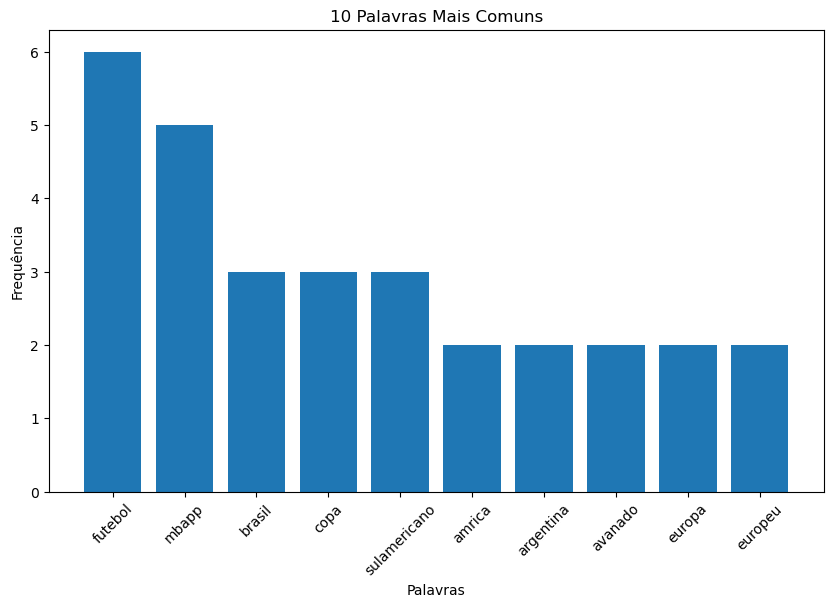

In [60]:
first_ten_elements = sorted_ttt[:10]

palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in first_ten_elements:
    palavras.append(word)
    contagens.append(count)


# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

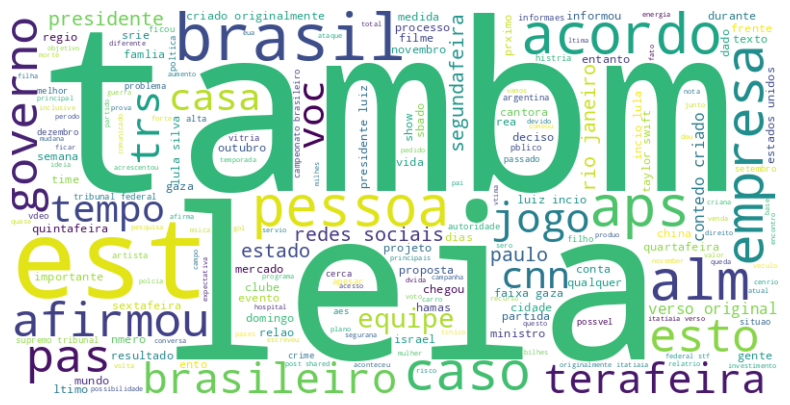

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token3])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
from gensim.models import LdaModel

ldamodel = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=50)

for topic in ldamodel.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.006*"governo" + 0.005*"tambm" + 0.004*"bilhes" + 0.004*"leia" + 0.004*"brasil"')
Tópicos:  (1, '0.013*"presidente" + 0.010*"lula" + 0.007*"stf" + 0.007*"ministro" + 0.007*"federal"')
Tópicos:  (2, '0.010*"israel" + 0.009*"gaza" + 0.008*"hamas" + 0.007*"rio" + 0.007*"brasil"')
Tópicos:  (3, '0.012*"polcia" + 0.006*"tambm" + 0.006*"federal" + 0.004*"cnn" + 0.004*"caso"')
Tópicos:  (4, '0.006*"tambm" + 0.006*"cantora" + 0.005*"est" + 0.005*"voc" + 0.005*"redes"')
Tópicos:  (5, '0.007*"brasileiro" + 0.006*"paulo" + 0.005*"leia" + 0.004*"tambm" + 0.004*"est"')
